In [1]:
import sys 
from pathlib import Path
sys.path.append(str(Path().cwd().parent))

import numpy as np
import matplotlib.pyplot as plt
from src.core import MeasurementStatisticsSimulator
from src.sim_funcs import decaying_poisson, perfect_poisson, perfect_entangling_noise, cascade_cnots_entangling_noise, snr
from src.utils import plot_constant_error, plot_lowest_errors, dir_images, TimeStep, var
from src.analytic_snr import analytic_snr, expectation_0, expectation_1, expectation_cnot, variance_cnot

In [2]:
mu0 = 35/10
mu1 = 140/10
lam = -np.log(0.96)/10
p = 0.01

t_list = np.append(np.arange(0.01, 10, 0.2), np.arange(10, 30, 1))
q_list = np.arange(1, 11)

In [3]:
sim = MeasurementStatisticsSimulator(1, perfect_entangling_noise, {}, perfect_poisson, {"mu": mu0}, decaying_poisson, 
                                                 {"mu0": mu0, "mu1": mu1, "lam": lam}, None, {}, snr, {})
sim.find_k_max(t_list[-1], int(2*t_list[-1]*mu1), False)
sim.simulate(t_list)
sim.calculate_error()

Simulating N=1, k_max=812, t=29.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.67s/it]


Simulating N=1, k_max=508, t=29.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [03:13<00:00,  2.76s/it]


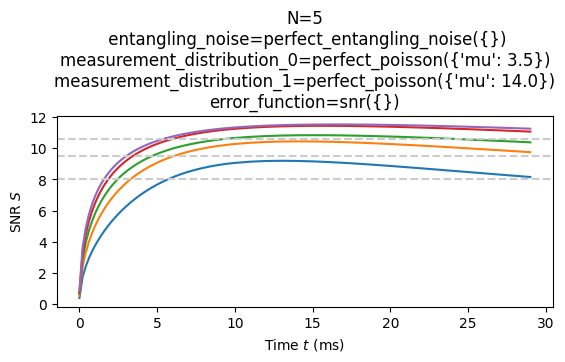

In [4]:
fontsize = 10

# We can make use of equation (20) in the supp mat so we don't need to perform numerical simulations on the statistics
E0 = expectation_0(mu0)
E1 = expectation_1(mu0, mu1, lam)
V0 = E0

# Haven't solved analytic expression for decaying poisson variance yet so will have to use the numerical one, 
# but we only need to find the variance for N=1 then we can use equation (20)
def numerical_var(sim_ = sim):
    def numerical_var_func(t):
        indx = sim_.get_time_and_error()[1].index(t)
        dist_1 = sim_.result[indx].measurement_distribution_1
        outcomes = np.arange(len(dist_1))
        
        return var(dist_1, outcomes)

    return numerical_var_func

V1 = numerical_var()
ET = expectation_cnot(p, cascade_cnots_entangling_noise)
VT = variance_cnot(p, cascade_cnots_entangling_noise)

sim_list = []
for N in q_list:
    # We still create Simulators to make use of the plotting functions but will manually add the results found with (20)
    sim = MeasurementStatisticsSimulator(N, perfect_entangling_noise, {}, perfect_poisson, {"mu": mu0}, perfect_poisson, 
                                                 {"mu": mu1}, None, {"eta": mu1-mu0}, snr, {})
    sim.result = [TimeStep(t, [], [], None, analytic_snr(E0, E1, E0, V1, ET, VT, N, t)) for t in t_list]
    sim_list.append(sim)

fig, ax = plt.subplots()
for sim in sim_list[:5]:
    sim.plot_error(label=f"{sim.N} Qubit{'' if sim.N == 1 else 's'}")

error_list = (8, 9.5, 10.6)
for err in error_list:
    plt.axhline(y=err, color='0.8', linestyle='--')

plt.xlabel(r"Time $t$ (ms)", fontsize=fontsize)
plt.ylabel(r"SNR $S$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(np.arange(0, 13, 2), fontsize=fontsize)

ax.set_aspect(1)
plt.show()

In [5]:
# fig.savefig(dir_images/"snr_noisy_experimental_squashed_import.svg", format="svg", dpi=300)

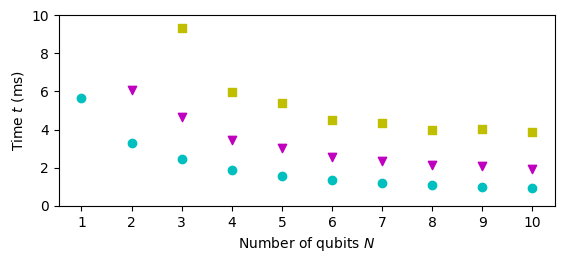

In [6]:
fig, ax = plt.subplots()

for error, color, marker in zip(error_list, ("c", "m", "y"), ("o", "v", "s")):
    plot_constant_error(sim_list, error, label=fr"$S={error}$", color=color, marker=marker)
    
plt.xlabel("Number of qubits $N$", fontsize=fontsize)
plt.ylabel("Time $t$ (ms)", fontsize=fontsize)
plt.xticks(range(1,11,1), fontsize=fontsize)
plt.ylim(0, 10)

ax.set_aspect(0.38)
plt.show()

In [7]:
# fig.savefig(dir_images/"snr_noisy_experimental_const_snr_squashed_import.svg", format="svg", dpi=300)

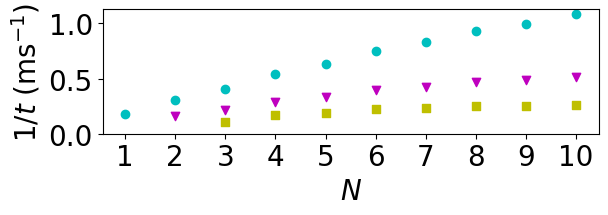

In [8]:
fontsize = 20

fig, ax = plt.subplots()
for error, color, marker in zip(error_list, ("c", "m", "y"), ("o", "v", "s")):
    plot_constant_error(sim_list, error, False, True, label=fr"$S={error}$", color=color, marker=marker)

plt.xlabel("$N$", fontsize=fontsize)
plt.ylabel("$1/t$ (ms$^{-1}$)", fontsize=fontsize)
plt.xticks(range(1,11,1), fontsize=fontsize)
plt.yticks(np.arange(0, 1.1, 0.5), fontsize=fontsize)

ax.set_aspect(2.2)
plt.show()

In [9]:
# fig.savefig(dir_images/"snr_noisy_experimental_const_snr_inset_squashed_import.svg", format="svg", dpi=300)

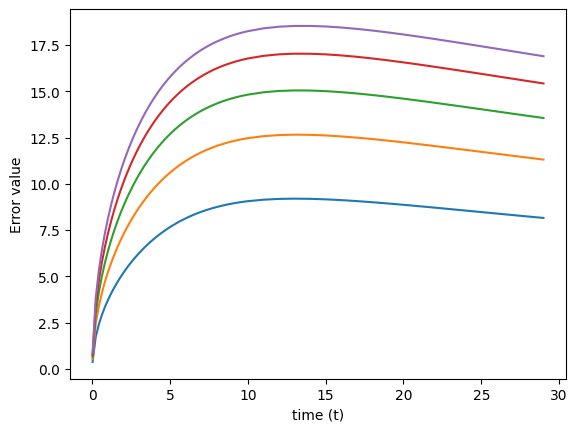

In [11]:
# Generate data for a lower CNOT error system for comparison
p = 0.001

ET = expectation_cnot(p, cascade_cnots_entangling_noise)
VT = variance_cnot(p, cascade_cnots_entangling_noise)

sim_list_comp = []
for N in q_list:
    sim = MeasurementStatisticsSimulator(N, perfect_entangling_noise, {}, perfect_poisson, {"mu": mu0}, perfect_poisson, 
                                                 {"mu": mu1}, None, {}, snr, {})
    sim.result = [TimeStep(t, [], [], None, analytic_snr(E0, E1, E0, V1, ET, VT, N, t)) for t in t_list]
    sim_list_comp.append(sim)

fig, ax = plt.subplots()
for sim in sim_list_comp[:5]:
    sim.plot_error(label=f"{sim.N} Qubit{'' if sim.N == 1 else 's'}")

plt.title("")
plt.show()

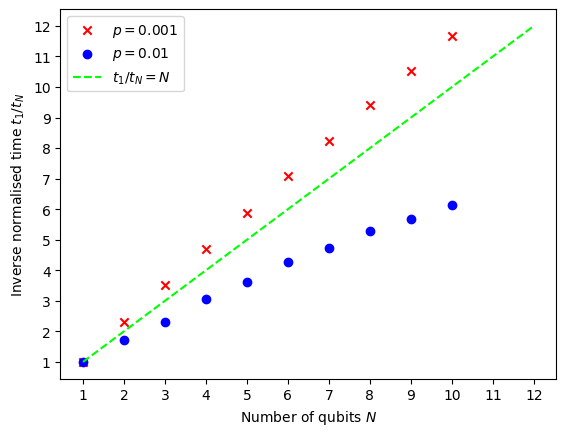

In [12]:
fontsize = 10
error = 8

plot_constant_error(sim_list_comp, error, True, True, marker="x", color="r", label=r"$p=0.001$")
plot_constant_error(sim_list, error, True, True, marker="o", color="b", label=r"$p=0.01$")
plt.plot(np.arange(1,13), np.arange(1,13), color="lime", linestyle="--", label="$t_1/t_N=N$")

plt.xlabel("Number of qubits $N$", fontsize=fontsize)
plt.ylabel("Inverse normalised time $t_1/t_N$", fontsize=fontsize)
plt.legend(prop={'size': fontsize})
plt.xticks(range(1,13,1), fontsize=fontsize)
plt.yticks(range(1,13,1), fontsize=fontsize)
plt.show()

In [15]:
# fig.savefig(dir_images/"snr_noisy_experimental_speed_up.svg", format="svg", dpi=300)

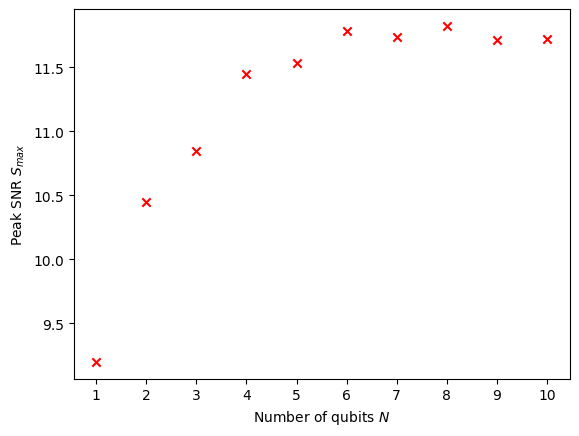

In [13]:
fig, ax = plt.subplots()
plot_lowest_errors(sim_list)
plt.xticks(range(1,11))
plt.xlabel("Number of qubits $N$")
plt.ylabel("Peak SNR $S_{max}$")
plt.show()

In [12]:
# fig.savefig(dir_images/"snr_noisy_experimental_highest_achieveable.svg", format="svg", dpi=300)